<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/lab_solutions/Labs/Lab11_Multidimensional_integration_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Multidimensional integration SOLUTIONS

### Learning objectives
- Learn how to formulate multidimensional integrals
  - Basically we do it the way it is defined in Calc 3
- See that, conceptually, integration in multiple dimensions (over rectangles) is straightforward
  - and not that bad over some non-rectangular regions
- Learn how to call `scipy`'s 2D integration function
- See how the cost scales with dimension
  - So while conceptually multidimensional integration is straightforward, there are major practical issues
- Look at an alternative for high dimensions: [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration)
  - Understand pros and cons of MC vs quadrature


### Tasks
1. Write your own 2D integration
2. Try integration in *arbitrary* dimensions $d\ge 1$
3. Look at Monte Carlo as an alternative

### Deliverables
- For the given function in the arbitrary dimension part (task 2), estimate how long (in appropriate time units) it would take to do the integral in 10 dimensions.  Write this down and turn it in via a PDF to Canvas


*APPM 4600. Copyright 2025 Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause license*

In [1]:
import numpy as np
import scipy.integrate
import functools # used for decorators
from matplotlib import pyplot as plt
import time
import scipy.stats

## Background
Before, we talked about 1D integrals
$$\int_a^b f(x)\,dx$$
and now let's talk about 2D integrals
$$\int_a^b \int_c^d f(x,y)\,dy dx$$
and later we can generalize to triple or higher-dimensional integrals.

Our trick is to reduce this to repeated 1D integrals:
$$\int_a^b \underbrace{\int_c^d f(x,y)\,dy}_{\varphi(x)} dx = \int_a^b \varphi(x)\,dx$$
where
$$\varphi(x) = \int_c^d f(x,y)\,dy.$$

More generally, we could have
$$\varphi(x) = \int_{g(x)}^{h(x)} f(x,y)\,dy$$
if the regions of integration are not rectangular. (*We're using $g$ and $h$ to match the terminology in the documentation of [`scipy.integrate.dblquad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html)*)

So, all you need to do is define a function $\varphi$ which computes a 1D integral, and then pass this function to another 1D integration routine.

For this lab, you do not need to code 1D integration routines yourself. You can (and should) use `scipy.integrate.quad` to do all the 1D integration. You can find documentation at:
- https://docs.scipy.org/doc/scipy/reference/integrate.html
- https://docs.scipy.org/doc/scipy/tutorial/integrate.html

## Task 1
### Task 1b

Find the integral
$$I = \int_{a=0}^{b=1} \int_{c=1}^{d=4} \underbrace{ \sqrt{\frac{x}{y} }}_{f(x,y)}\,dy\,dx$$
*This is from exercise 21 in section 13.1 in "Calculus" 2nd ed. by Briggs, Cochran and Gillett*
The true answer, which you could work out pen-and-paper, is $I=\frac{4}{3}$, so we will use this to check our answer.

**Tasks**:
1. Estimate this integral using scipy's `scipy.integrate.dblquad` which is for 2D quadrature. Look at the documentation to see how to use it
2. Estimate the integral yourself without using `dblquad`.  You *can* use any 1D integration routines, like `scipy.integrate.quad`

In [2]:
# SOLUTIONS
a, b = 0, 1
c, d = 1, 4
f = lambda x,y : np.sqrt(x/y)
I = 4/3 # true answer from back of book

I_n, err_est = scipy.integrate.dblquad( lambda  y,x : f(x,y), a, b, c, d, epsabs = 1e-12, epsrel = 1e-12)
print(f'Dimension 2, true integral {I:.16f}, our estimate is {I_n:.16f}, error is {abs(I-I_n):.2e}')

Dimension 2, true integral 1.3333333333333333, our estimate is 1.3333333333333333, error is 0.00e+00


In [3]:
# SOLUTIONS
# Let's do it ourselves
def phi(x):
    return scipy.integrate.quad( lambda y : f(x,y), c, d)[0]

I_n = scipy.integrate.quad( phi, a, b )[0]
print(f'Dimension 2, true integral {I:.16f}, our estimate is {I_n:.16f}, error is {abs(I-I_n):.2e}')

Dimension 2, true integral 1.3333333333333333, our estimate is 1.3333333333333333, error is 0.00e+00


### Task 1b
Let's do another integral:
$$I=\int_0^{\sqrt{\pi}} \underbrace{ \int_x^{\sqrt{\pi}} \sin( y^2) \,dy}_{\varphi(x)}\,dx$$

To find a closed-form answer, doing it in this order isn't easy, since $\sin(y^2)$ doesn't have a closed-form antiderivative (in terms of elementary functions).  By visualizing the region of integration, which is
$$R = \{ (x,y): 0 \le x \le \sqrt{\pi},\; 0 \le y \le \sqrt{\pi},\; y \ge x\}$$
we see that we can rewrite it as
$$I=\int_0^{\sqrt{\pi}} \underbrace{ \int_0^{y} \sin( y^2) \,dx}_{\psi(y)}\,dy$$
and $\psi(y) = \int_0^{y} \sin( y^2) \,dx = \sin( y^2) \int_0^{y}  \,dx = y\sin(y^2)$
and so $I = \int_0^{\sqrt{\pi}} y\sin(y^2)\,dy$ which can be done in closed form since we recognize $d/dy \frac{-1}{2}\cos(y^2) = y\sin(y^2)$ so we get $I= -\frac12\cos(y^2)\Big|_0^{\sqrt{\pi}} = 1$.  *This is a slight modification of Example 4 in section 13.2 of "Calculus" 2nd ed. by Briggs, Cochran and Gillett*

**Tasks**:
- using `scipy.integrate.dblquad`.  Note that this function wants "x" and "y", but mathematically it doesn't matter what you call x and what you call y, so you are free to switch these up if that's more convenient!  That is, $\int_0^{\sqrt{\pi}} \int_x^{\sqrt{\pi}} \sin( y^2) \,dy\,dx=\int_0^{\sqrt{\pi}} \int_y^{\sqrt{\pi}} \sin( x^2) \,dx\,dy$ sinc "x" and "y" are just labels and we're free to switch them up.
- do it yourself, with $\varphi$ as the inner function. Don't use `dblquad`, but you may use `quad`.
- do it yourself, with $\psi$ as the inner function. Don't use `dblquad`, but you may use `quad`.

In [4]:
# SOLUTIONS
def f(x,y):
    return np.sin(y**2)

I = 1 # using the formula we derived by hand

# Let's do it in scipy
a, b = 0, np.sqrt(np.pi)
I_n, err_est = scipy.integrate.dblquad( lambda  y,x : f(x,y), a, b, lambda x : x, np.sqrt(np.pi), epsabs = 1e-12, epsrel = 1e-12)
print(f'Dimension 2, true integral {I:.16f}, our estimate is {I_n:.16f}, error is {abs(I-I_n):.2e} (using dblquad)')

# Let's do it the first way:
a, b = 0, np.sqrt(np.pi)
def phi(x):
    return scipy.integrate.quad( lambda y : f(x,y), x, np.sqrt(np.pi))[0]
I_n = scipy.integrate.quad( phi, a, b )[0]
print(f'Dimension 2, true integral {I:.16f}, our estimate is {I_n:.16f}, error is {abs(I-I_n):.2e} (our own method, with phi)')

# and let's try it the second way too:
def psi(y):
    return scipy.integrate.quad( lambda x : f(x,y), 0, y)[0]
I_n = scipy.integrate.quad( psi, 0, np.sqrt(np.pi) )[0]
print(f'Dimension 2, true integral {I:.16f}, our estimate is {I_n:.16f}, error is {abs(I-I_n):.2e} (our own method, with psi)')

Dimension 2, true integral 1.0000000000000000, our estimate is 1.0000000000000000, error is 0.00e+00 (using dblquad)
Dimension 2, true integral 1.0000000000000000, our estimate is 1.0000000000000000, error is 0.00e+00 (our own method, with phi)
Dimension 2, true integral 1.0000000000000000, our estimate is 0.9999999999999999, error is 1.11e-16 (our own method, with psi)


## Task 2: extend to arbitrary dimensions

Let $f(\vec{x}) = e^{-\|\vec{x}\|_2^2/2}$ which happens to be the unnormalized pdf of the [multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution).

Then it's known that
$$I = \int_{\mathbb{R}^d} \underbrace{ e^{-\|\vec{x}\|_2^2/2} }_{f(\vec{x})}\,d\vec{x} = \sqrt{ (2\pi)^d }.$$

Our job is to estimate this.  This function is well defined for any dimension $d\ge 1$, so we can look at how the methods scale with dimension $d$.

One little issue is that the integration is defined over an infinite domain. For our purposes, let's restrict to the hypercube domain $[-7,7]^d$, since $f(\vec{x})$ is pretty small outside that region.

**Specific tasks**:
- Estimate this integral in dimension 1 using 1D quadrature (so you should get $I=\sqrt{2\pi}$), using `scipy.integrate.quad`
  - You can verify that restricting to $[-7,7]$ has little effect.
- Estimate this integral in dimension 2 using `scipy.integrate.nquad` which is the generic multidimensional quadrature routine that handles any dimension. Make sure your answer is correct
- Now for dimensions $d=1,2,3,4$, run `scipy.integrate.nquad` and **record how long it takes**
  - One way to time it is to use `time.time` to get the current time (in seconds)
- Determine a pattern (use your scientific common sense) and **predict** how long it would take to do this in dimension $d=10$


In [5]:
# We have some functions defined for you that will help with the programming
def f(x):
    """ x is a vector of dimension d
    Note: scipy.integrate.nquad does *not* work with a function like this.
    It wants to pass in each component of the vector separately.
    For that kind of using, see the F( ) function below
    """
    r = np.linalg.norm(x)
    return np.exp( -r**2/2 )

def F(*args):
    """ the input is a list of the components of a vector,
    like F(x,y,z). This function then converts these into
    a vector [x,y,z] and passes that to f
    """
    return f( np.array(args) )

# Do it in 1D as a sanity check. [-7,7] is sufficient for about 11 digits of accuracy
d = 1 # dimension
I = np.sqrt( (2*np.pi)**d ) # the normalization factor for a Gaussian pdf

# SOLUTIONS
a, b = -7, 7
I_n, err_est = scipy.integrate.quad( f, a,b)
print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_n:.5}, rel error is {abs(I-I_n)/I:.2e}')

dim = 1, true integral is 2.5066, our estimate is 2.5066, rel error is 2.56e-12


In [6]:
# SOLUTIONS
d = 2 # dimension
I = np.sqrt( (2*np.pi)**d )

I_n, err_est = scipy.integrate.dblquad( F, a, b, a, b)
print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_n:.5}, rel error is {abs(I-I_n)/I:.2e}')

dim = 2, true integral is 6.2832, our estimate is 6.2832, rel error is 5.12e-12


In [7]:
# SOLUTIONS
d = 2 # dimension
I = np.sqrt( (2*np.pi)**d )

bounds = np.tile( (a,b), (d,1) )
I_n, err_est = scipy.integrate.nquad( F, bounds)
print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_n:.5}, rel error is {abs(I-I_n)/I:.2e}')

d = 3 # dimension
I = np.sqrt( (2*np.pi)**d )

bounds = np.tile( (a,b), (d,1) )
I_n, err_est = scipy.integrate.nquad( F, bounds)
print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_n:.5}, rel error is {abs(I-I_n)/I:.2e}')

dim = 2, true integral is 6.2832, our estimate is 6.2832, rel error is 5.12e-12
dim = 3, true integral is 15.75, our estimate is 15.75, rel error is 7.68e-12


In [8]:
# SOLUTIONS
# Loop over several dimensions and record the time

dimList = np.arange(1,5)
timeList = []
for d in dimList:
    I = np.sqrt( (2*np.pi)**d )
    bounds = np.tile( (a,b), (d,1) )
    tic = time.time()
    I_n, err_est = scipy.integrate.nquad( F, bounds)
    toc = time.time()
    timeList.append( toc - tic )
    print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_n:.5}, rel. error is {abs(I-I_n)/I:.2e}, took {toc-tic:.5f} seconds')


dim = 1, true integral is 2.5066, our estimate is 2.5066, rel. error is 2.56e-12, took 0.00290 seconds
dim = 2, true integral is 6.2832, our estimate is 6.2832, rel. error is 5.12e-12, took 0.09290 seconds
dim = 3, true integral is 15.75, our estimate is 15.75, rel. error is 7.68e-12, took 6.79353 seconds
dim = 4, true integral is 39.478, our estimate is 39.478, rel. error is 1.02e-11, took 597.79809 seconds


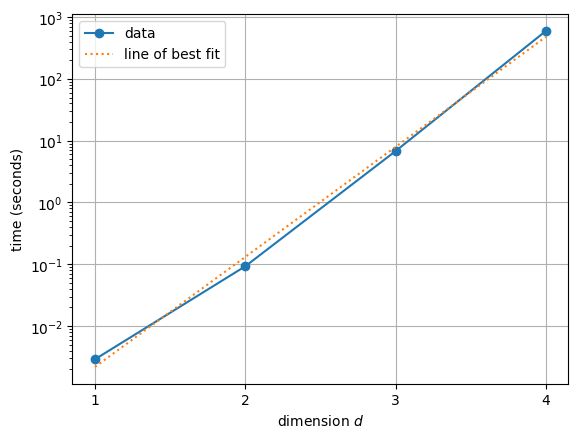

d =  5, predicted time is          8.0 hours
d =  6, predicted time is         20.2 days
d =  7, predicted time is          3.3 years
d =  8, predicted time is        201.4 years
d =  9, predicted time is      12150.0 years
d = 10, predicted time is     733026.6 years
d = 11, predicted time is   44224393.8 years
d = 12, predicted time is 2668112013.6 years


In [9]:
# SOLUTIONS
plt.semilogy( dimList, timeList, 'o-',label='data')

# To find a line of best fit, you can either eyeball it, like:
# plt.semilogy( dimList, 1e-5*50**dimList)

# ... or do a little least squares, using scipy.linalg.lstsq or scipy.stats.linregress
# (but either way, do a log transormation of time!)
result = scipy.stats.linregress( dimList, np.log(timeList) )
plt.semilogy( dimList, np.exp(result.intercept + result.slope*dimList), ':', label='line of best fit')
plt.xlabel('dimension $d$')
plt.ylabel('time (seconds)')
plt.xticks(dimList)
plt.legend()
plt.grid()
plt.show()

for d in range(5,13):
    tm = np.exp(result.intercept + result.slope*d) # in seconds
    units = 'seconds'
    if tm > 60:
        tm /= 60
        units = 'minutes'
    if tm > 60:
        tm /= 60
        units = 'hours'
    if tm > 24:
        tm /= 24
        units = 'days'
    if tm > 365:
        tm /= 365
        units = 'years'
    print(f'd = {d:2d}, predicted time is {tm:12.1f} {units}')

So for $d=10$, the answer depends of course on your computer, but it should be on the order of 500,000 years to 1,500,000 years!

## Task 3: Monte Carlo integration

If $Z$ is a random variable with probability density function (pdf) given by $p(Z)$, then we define its **mean** or **expected value** (or "first moment") as
$$\mathbb{E}[Z] = \int_{-\infty}^\infty Z \cdot p(Z)\,dZ$$
and we can also define the expected value of a (possibly multivariate) function $f:\mathbb{R}^d\to\mathbb{R}$
$$\mathbb{E}[f(\vec{x})] = \int_{-\infty}^\infty f(\vec{x}) \cdot p(\vec{x})\,d\vec{x}$$
and we can estimate means by using the sample mean: if we draw $\vec{x}_1,\ldots,\vec{x}_n$ independently from the distribution with pdf $p$, then
$$\hat{\mu}_n := \frac{1}{n}\sum_{i=1}^k f( \vec{x}_i )$$
and
$$\lim_{n\to\infty} \hat{\mu}_n  = \mu := \mathbb{E}[f(\vec{x})]$$
by the law of large numbers.  

So one can compute expected values by using integration techniques. The idea of **Monte Carlo** methods (really, an entire *field* of methods, named after the famous casino in Monaco) flips this idea on its head: let's use statistics to compute integrals. i.e., use the sample mean to estimate the integral.
The error in this estimate is $O(1/\sqrt{n})$ which is **very bad** compared to quadrature, but it is **independent of dimension**.

If possible, you should avoid Monte Carlo in small dimensions because it's very inaccurate and quadrature is so good. But in dimension 10 (much less 1000 or a million) you cannot use quadrature.  Monte Carlo is never great for high accuracy (like 10 digits of precision) but it's sometimes your only choice.  There are also thousands of research papers on variants that improve vanilla Monte Carlo. In our context, a few common tricks are things like *control variates* and *quasi Monte-Carlo*.  If you're interested in learning more, we have an introductory demo on [Monte Carlo and variants](https://github.com/stephenbeckr/randomized-algorithm-class/blob/master/Demos/demo14_MonteCarlo_and_improvements.ipynb) as a colab notebook as part of APPM/STAT 5650 "Randomized Algorithms".

In the example below, let's choose the distribution $\vec{X}$ to be uniform from the hypercube $H=[-4,4]^d$, so the volume of this hypercube is $8^d$ and hence $p(\vec{x}) = 8^{-d}$. So then we write
$$
\int_{\mathbb{R}^d} f(\vec{x}) \,d\vec{x} \approx \int_H f(\vec{x}) \,d\vec{x} = 8^d \int_H f(\vec{x}) \cdot p(\vec{x}) \,d\vec{x} \approx \frac{8^d}{n} \sum_{i=1}^n f(\vec{x}_i)
$$
where the $\vec{x}_i$ are drawn uniformly and independently from the hypercube $H$.

**Specific tasks**:
- Run Monte Carlo for dimension $d=1$ to make sure it's working
  - You can generate uniformly random numbers using numpy's library
  - One way to do this is `rng = np.random.default_rng();  X = rng.random( (m,d) )` to return a matrix of $m\times d$ numbers all drawn uniformly from $[0,1]$ (so you'll have to modify this a little bit)
- Now do it in dimension $d=10$.  How many points to do you need to get a relative error of 2 or 3 digits?

In [10]:
# SOLUTIONS
rng = np.random.default_rng(67)
d       = 10 # dimension
I       = np.sqrt( (2*np.pi)**d )
nPoints = int(1e7)  # SOLUTION: we need at least a million (or 10) or so points to get 1e-2 or so accuracy
# We generate all the points at once for efficiency, and use vectorization
# However, if we have over 1e7 points, we may start to have memory issues. In that case,
# you should loop over blocks of points

def f_vectorized(X):
    """ For efficiency, this allows the input to be a series of d-dim vectors
    In particular, X can be a matrix with d columns and as many rows as you want.
    The size of the output will be the same as the number of rows """
    r = np.linalg.norm(np.atleast_2d(X), axis=1)
    return np.exp( -r**2/2 )

b = 4
V = (2*b)**d # volume of the [-b,b] hypercube
X = 2*b*rng.random( (nPoints,d)) - b # uniformly at random in [-b,b]
I_MonteCarlo = V*f_vectorized(X).mean()
print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_MonteCarlo:.5}, rel. error is {abs(I-I_MonteCarlo)/I:.2e}')

dim = 10, true integral is 9792.6, our estimate is 9671.0, rel. error is 1.24e-02


In [11]:
# If we want more accuracy, we can loop
nPoints = int(1e6)
nLoops  = 1000
I_MonteCarlo = 0.
for loop in range(nLoops):
    X = 2*b*rng.random( (nPoints,d)) - b # uniformly at random in [-b,b]
    I_MonteCarlo += V*f_vectorized(X).mean()
I_MonteCarlo /= nLoops
print(f'dim = {d}, true integral is {I:.5}, our estimate is {I_MonteCarlo:.5}, rel. error is {abs(I-I_MonteCarlo)/I:.2e}, used n = {nLoops*nPoints}')

dim = 10, true integral is 9792.6, our estimate is 9789.8, rel. error is 2.88e-04, used n = 1000000000
